# **Uczenie Maszynowe - LAB2b - LIME**

Biblioteka LIME: https://github.com/marcotcr/lime (Dokumentacja API: https://lime-ml.readthedocs.io/en/latest/)

# **Wprowadzenie - pakiety**

Niezbędne pakiety i moduły na potrzeby wprowadzenia

In [1]:
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms

# Wprowadzenie - funkcje pomocnicze

Funkcja do wczytywania wskazanego obrazka oraz konwersji do palety RGB.

In [2]:
def get_image(path):
    with open(path, "rb") as f:
        with Image.open(f) as img:
            return img.convert("RGB")

Funkcja do przekształcania obrazka (zwróconego przez funkcję `get_image`) w tensor, akceptowalny na wejściu sieci neronowej.

In [3]:
def image_to_tensor(img):
    transformer = transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    return transformer(img).unsqueeze(0)

Funkcja używana przez LIME, przyjmuje na wejściu zbiór obrazków, a zwraca prawdopodobieństwa klas. Należy ją przekazać do `lime_image.LimeImageExplainer().explain_instance` przy użyciu `partial`, jako `partial(predict_batch, <model>)`, gdzie modelem w naszym wypadku będą sieci neuronowe. Przykłady użycia są zawarte w tym notebooku.

In [4]:
def predict_batch(model, images):
    model.eval()
    transformer = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    model.eval()
    batch = torch.stack(tuple(transformer(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probas = torch.nn.functional.softmax(logits, dim=1)
    return probas.detach().cpu().numpy()

Funkcja, która przekształca obrazek w format akceptowany na wejściu przez LIME. Przykłady użycia są zawarte w tym notebooku.

In [5]:
def lime_transformer(image):
    transformer = transforms.Compose(
        [transforms.Resize((256, 256)), transforms.CenterCrop(224)]
    )
    return np.array(transformer(image))

LIME jest głównie wykorzystywane do **wyjaśniania** predykcji tzw. czarnych skrzynek, czyli modeli nieinterpretowalnych. Idealnymi kandydatami są Głębokie Sieci Neuronowe, dlatego spróbujemy wyjaśnić niektóre predykcje gotowych modeli.

# **Model Inception-v3 - przygotowanie danych**
https://arxiv.org/abs/1512.00567

Plik `./data/imagenet_class_index.json` zawiera przypisanie klas obrazków do indeksów. Jest to istotne, ponieważ zwracane wyniki (np. wartości funkcji logit na wyjściu sieci neuronowych) wykorzystują to, zwracając wyniki w zadanej kolejności.

In [6]:
with open("./data/imagenet_class_index.json") as f:
    content = json.load(f)
    index_to_label = {int(index): data[1] for index, data in content.items()}

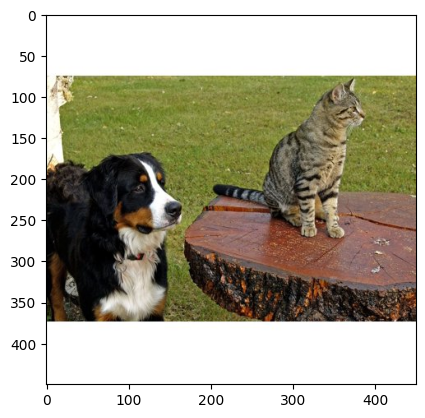

In [7]:
image_to_classify = get_image("./data/dogs.png")
plt.imshow(image_to_classify)

In [8]:
img_tensor = image_to_tensor(image_to_classify)

### **Załadowanie pretrenowanego modelu**

In [9]:
inception_v3 = models.inception_v3(pretrained=True)

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Predykcja**

In [10]:
inception_v3.eval()
logits = inception_v3(img_tensor)

Zwróć uwagę, że model zwraca wartości funkcji logit, a nie prawdopodobieństwa klas, dlatego wyniki trzeba przetworzyć (np. przy użyciu funkcji softmax).

In [11]:
probas = torch.nn.functional.softmax(logits, dim=1)

Sprawdźmy N najbardziej prawdopodobnych klas

In [12]:
TOP_N_LABELS = 15

probas_top = probas.topk(TOP_N_LABELS)
top_probas = probas_top[0][0].detach().numpy()
top_labels = probas_top[1][0].detach().numpy()
for proba, label in zip(top_probas, top_labels):
    print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

Class: Bernese_mountain_dog           | Probability: 0.935930
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001


### **Teraz możemy te funkcje zebrać razem**

In [13]:
def get_prediction_probabilities(image, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_tensor = image_to_tensor(image).to(device)
    model.eval()
    model.to(device)
    logits = model(img_tensor)
    probas = torch.nn.functional.softmax(logits, dim=1)

    probas_top = probas.topk(TOP_N_LABELS)
    top_probas = probas_top[0][0].cpu().detach().numpy()
    top_labels = probas_top[1][0].cpu().detach().numpy()
    for proba, label in zip(top_probas, top_labels):
        print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

### **I sprawdzić jak ta predykcja wygląda dla innego obrazka**

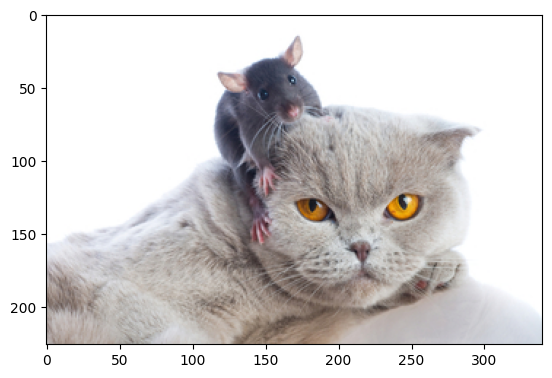

In [14]:
exercise_image = get_image("./data/cat_mouse.jpeg")
plt.imshow(exercise_image)

## **Zadanie: sprawdź jak będzie wyglądała predykcja dla powyższego obrazka**

In [15]:
get_prediction_probabilities(exercise_image, inception_v3)

Class: Egyptian_cat                   | Probability: 0.966676
Class: tabby                          | Probability: 0.024817
Class: lynx                           | Probability: 0.005550
Class: tiger_cat                      | Probability: 0.002244
Class: Persian_cat                    | Probability: 0.000112
Class: Angora                         | Probability: 0.000077
Class: swab                           | Probability: 0.000074
Class: Madagascar_cat                 | Probability: 0.000065
Class: snow_leopard                   | Probability: 0.000041
Class: tile_roof                      | Probability: 0.000038
Class: indri                          | Probability: 0.000020
Class: leopard                        | Probability: 0.000017
Class: Siamese_cat                    | Probability: 0.000011
Class: ram                            | Probability: 0.000011
Class: crate                          | Probability: 0.000010


# **Model Inception-v3 - wyjaśnienie**

Chcemy wiedzieć dlaczego klasa `Bernese_mountain_dog` została uznana przez sieć neuronową za najbardziej prawdopodobną (to znaczy - które piksele obrazka o tym zadecydowały). W tym celu właśnie wykorzystamy LIME.

W jaki sposób działa LIME na obrazkach?
1. Na wejściu wymagany jest oryginalny obrazek.
2. Wejściowy obrazek jest delikatnie przekształcany wiele razy, dzięki czemu otrzymujemy wiele podobnych (ale nie takich samych!) obrazków.
3. Dodatkowo na wejście musimy podać funkcję, która każdemu takiemu przekształceniu nada prawdopodobieństwo przynależności do danej klasy. Jest to wymagane ponieważ LIME jest niezależny od żadnych narzędzi i modeli.

In [16]:
explainer = lime_image.LimeImageExplainer()

In [17]:
explanation = explainer.explain_instance(
    image=lime_transformer(image_to_classify),
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Mając te dane możemy teraz sprawdzić które kategorie są najbardziej prawdopodobne

In [18]:
for index in explanation.top_labels:
    print(index_to_label[index])

Bernese_mountain_dog
EntleBucher
Appenzeller
Greater_Swiss_Mountain_dog
Gordon_setter


Zobaczmy co wpłynęło na wybranie `Bernese_mountain_dog` jako najbardziej prawdopodobnej klasy.

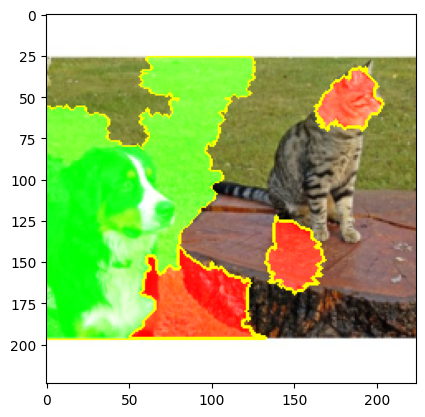

In [19]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

## **Zadanie: zmień wartość NUM_FEATURES i zaobserwuj jak zmienia się mapowanie**
NUM_FEATURES najlepiej zmieniać w zakresie 1:50

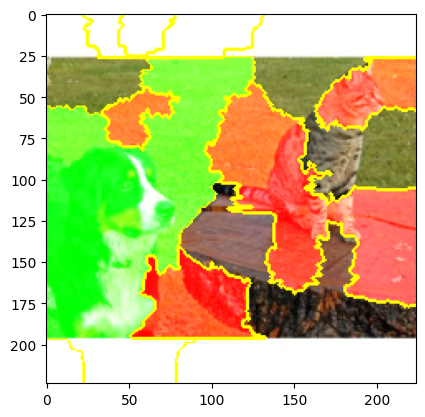

In [20]:
NUM_FEATURES = 20

image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=NUM_FEATURES,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

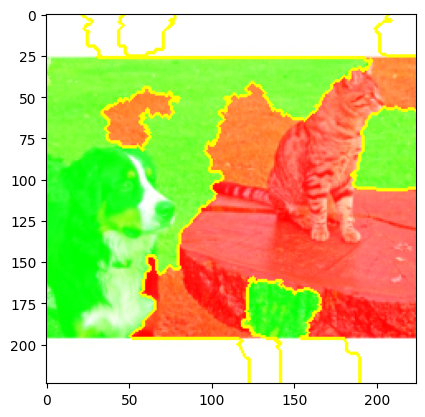

In [21]:
NUM_FEATURES = 50

image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=NUM_FEATURES,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Dużo zielonych obszarów dla cech nie pokrywa się ze zdjęciem psa. Nie jest to coś wskazanego, ale można założyć, że bardziej jest to spowodowane nie w pełni poprawnym działaniem modelu. Właśnie do badań takich problemów przydaje się explainable ML

Zielone fragmenty oznaczają "superpiksele", które pozytywnie wpływają na predykowaną klasę. Czerwone fragmenty wpływają negatywnie.

## **Zadanie-pytanie: co to właściwie jest superpiksel?**
## **Zadanie-pytanie: czy jeden superpiksel ma odzwierciedlenie w jednym pikselu z obrazka?**

Zobaczmy jak to się prezentuje dla drugiej najbardziej prawdopodobnej klasy, czyli `EntleBucher`, która jednak otrzymała jedyne 3.8%.

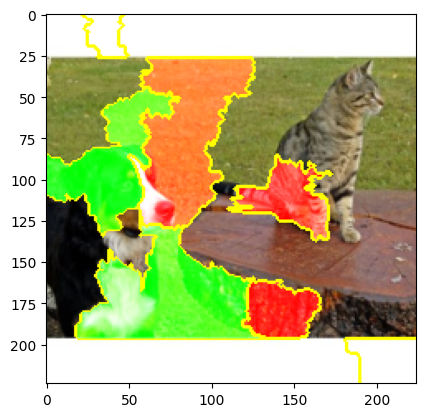

In [22]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[1],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Ustawiając wartości `hide_rest` oraz `positive_only` na `True` jesteśmy w stanie zostawić tylko te piksele, które potwierdzały przynależność do danej klasy <br>
Musimy jednak pamiętać o przeskalowaniu rezultatu przy pomocy `(boundaries).astype(np.uint8)`

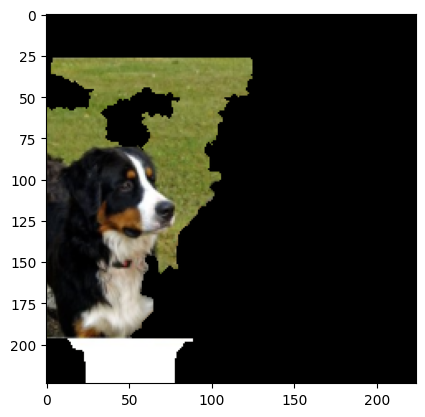

In [23]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=10,
    hide_rest=True,
)
boundaries = mark_boundaries(image, mask)
plt.imshow((boundaries).astype(np.uint8))

Możemy również zostawić tylko te piksele, które zaprzeczały przynależności do danej klasy

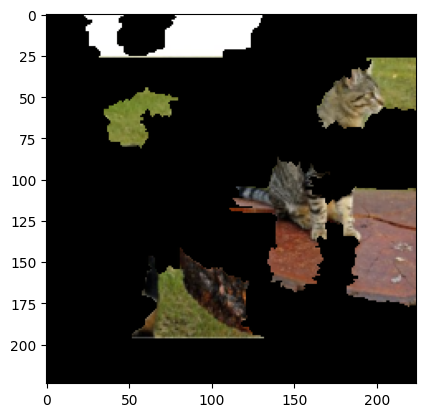

In [24]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True,
)
boundaries = mark_boundaries(image, mask)
cropped_image_ndarray = (boundaries).astype(np.uint8)
plt.imshow(cropped_image_ndarray)

A następnie sprawdzić co model sądzi o tak wyciętym obrazku

In [25]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, inception_v3)

Class: mortarboard                    | Probability: 0.462410
Class: feather_boa                    | Probability: 0.196128
Class: jigsaw_puzzle                  | Probability: 0.153839
Class: groom                          | Probability: 0.045062
Class: torch                          | Probability: 0.021538
Class: academic_gown                  | Probability: 0.019004
Class: theater_curtain                | Probability: 0.014819
Class: guillotine                     | Probability: 0.007824
Class: cinema                         | Probability: 0.005431
Class: wig                            | Probability: 0.003595
Class: tray                           | Probability: 0.003080
Class: grand_piano                    | Probability: 0.002927
Class: jersey                         | Probability: 0.002675
Class: jellyfish                      | Probability: 0.002483
Class: teddy                          | Probability: 0.002167


I jak go teraz widzi model

In [26]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil),
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

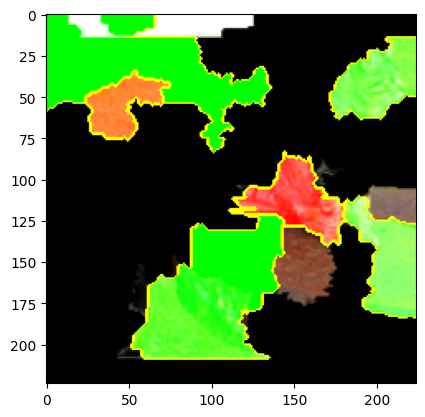

In [27]:
image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

# **Model Inception-v3 - porównanie z AlexNet**

Przetestujmy działanie na innym modelu - `AlexNet`

In [28]:
alexnet = models.alexnet(pretrained=True)

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
explanation_alexnet = explainer.explain_instance(
    image=lime_transformer(image_to_classify),
    classifier_fn=partial(predict_batch, alexnet),
    top_labels=5,
    num_samples=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [30]:
for index_alex, index_inception in zip(
    explanation_alexnet.top_labels, explanation.top_labels
):
    print(f"{index_to_label[index_alex]:30} | {index_to_label[index_inception]:30}")

Bernese_mountain_dog           | Bernese_mountain_dog          
EntleBucher                    | EntleBucher                   
Greater_Swiss_Mountain_dog     | Appenzeller                   
Appenzeller                    | Greater_Swiss_Mountain_dog    
basset                         | Gordon_setter                 


Jak widać, klasy nieco się różnią, ale TOP 1 pozostaje takie samo.

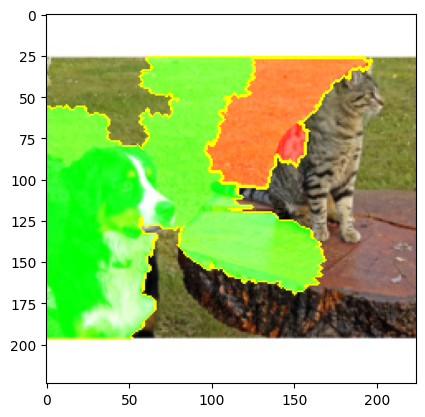

In [31]:
image, mask = explanation_alexnet.get_image_and_mask(
    label=explanation_alexnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Wyjaśnienie dla `AlexNet` jak się można było spodziewać - też się różni, jednak w dalszym ciągu do klasyfikacji psa istotny jest... pies :)

## **Zadanie: porównaj predykcje obrazka dla modeli inception_v3 oraz alexnet**

In [32]:
print("inception_v3")
get_prediction_probabilities(image_to_classify, inception_v3)
print()
print("alexnet")
get_prediction_probabilities(image_to_classify, alexnet)

inception_v3
Class: Bernese_mountain_dog           | Probability: 0.935340
Class: EntleBucher                    | Probability: 0.038841
Class: Appenzeller                    | Probability: 0.023942
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001829
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001

alexnet
Class: Bernese_mountain_dog           | Probabil

Model inception_v3 jest bardziej pewny swojego wyboru

# **Zadanie domowe - wstęp**
W folderze `data` znajduje się zdjęcie amfibii:
![title](data/amfibia.jpg)


In [33]:
amphibious_vehicle = get_image("./data/amfibia.jpg")

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

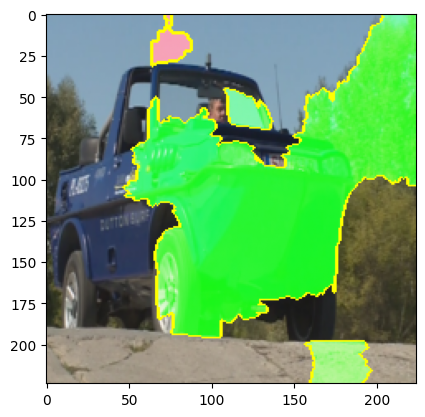

In [34]:
inception_v3 = models.inception_v3(pretrained=True)

explanation_amhibious_vehicle_inception_v3 = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle),
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000,
)

image, mask = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Model `inception_v3` jak i jego wyjaśnienie rzeczywiście sugerują amfibię jako najbardziej prawdopodobną klasę:

In [35]:
for index in explanation_amhibious_vehicle_inception_v3.top_labels:
    print(index_to_label[index])

amphibian
convertible
racer
car_wheel
golfcart


# Zadanie #1

Użyj dwóch różnych sieci neuronowych (poza inception_v3, którego przykład jest powyżej) do wygenerowania wyjaśnień.<br>
(skorzystaj z modułu torchvision: https://pytorch.org/vision/stable/models.html)

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

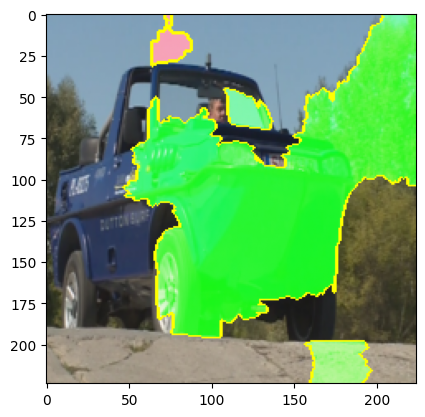

In [36]:
resnet = models.resnet.resnet18(pretrained=True)

explanation_resnet = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle),
    classifier_fn=partial(predict_batch, resnet),
    top_labels=5,
    num_samples=1000,
)

image_resnet, mask_resnet = explanation_resnet.get_image_and_mask(
    label=explanation_resnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)

boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

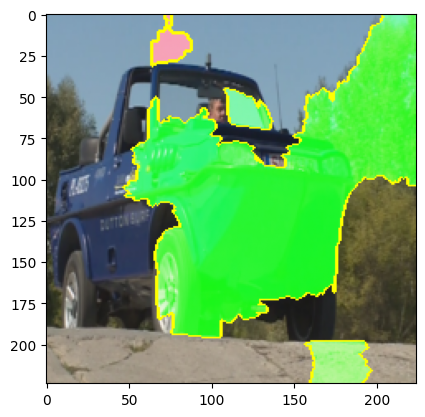

In [37]:
vision_transformer = models.vision_transformer.vit_b_32(pretrained=True)

explanation_vision_transformer = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle),
    classifier_fn=partial(predict_batch, vision_transformer),
    top_labels=5,
    num_samples=1000,
)

(
    image_vision_transformer,
    mask_vision_transformer,
) = explanation_vision_transformer.get_image_and_mask(
    label=explanation_vision_transformer.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)

boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [38]:
print("resnet")
get_prediction_probabilities(amphibious_vehicle, resnet)
print()
print("vision_transformer")
get_prediction_probabilities(amphibious_vehicle, vision_transformer)

resnet
Class: racer                          | Probability: 0.416398
Class: tow_truck                      | Probability: 0.234599
Class: pickup                         | Probability: 0.109450
Class: amphibian                      | Probability: 0.062788
Class: convertible                    | Probability: 0.042453
Class: sports_car                     | Probability: 0.029292
Class: jeep                           | Probability: 0.020250
Class: tractor                        | Probability: 0.016381
Class: car_wheel                      | Probability: 0.015873
Class: plow                           | Probability: 0.013685
Class: snowplow                       | Probability: 0.004457
Class: forklift                       | Probability: 0.003617
Class: chain_saw                      | Probability: 0.002143
Class: tank                           | Probability: 0.001823
Class: harvester                      | Probability: 0.001741

vision_transformer
Class: amphibian                      | Pro

ResNet nie rozpoznaje klasy poprawnie. Skupia się na bokach pojazdu ignorując przód/dziób który dla pozostałych modeli zdaje się być kluczowy do rozpoznania klasy.

# Zadanie #2

Zmodyfikuj oryginalny obrazek w taki sposób, żeby najbardziej prawdopodobną klasą dla każdej z tych sieci **nie była** amfibia a jakiś inny pojazd (np. samochód). W tym celu możesz "zasłonić" czarnym kwadratem (wartość 0 w macierzy reprezentującej obraz) obszary istotne przy klasyfikacji. <br>
Przydatną rzeczą będzie skorzystanie z opcji `hide_rest` w funkcji `get_image_and_mask` i późniejsza obróbka obrazu

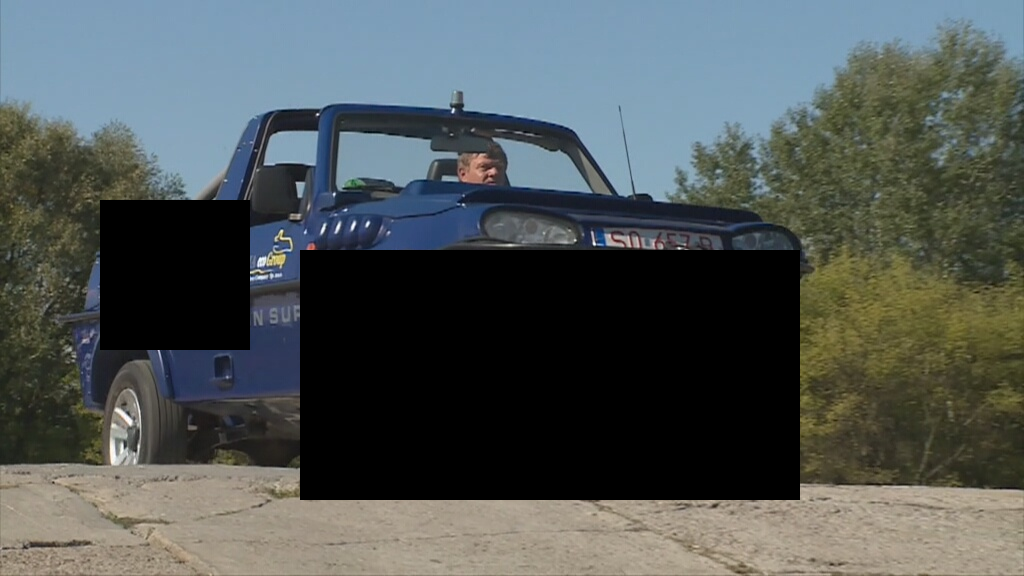

In [39]:
incorrect_amphibious_vehicle = np.copy(np.asarray(amphibious_vehicle))
incorrect_amphibious_vehicle[250:500, 300:800] = 0
incorrect_amphibious_vehicle[200:350, 100:250] = 0
incorrect_amphibious_vehicle = Image.fromarray(incorrect_amphibious_vehicle)
incorrect_amphibious_vehicle

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

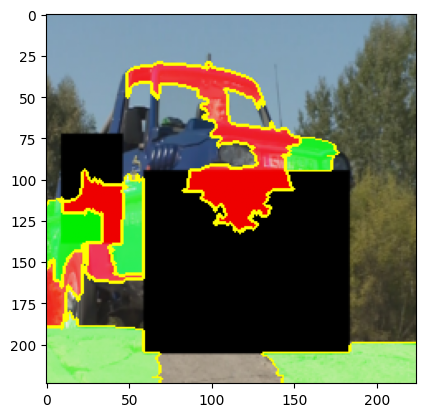

In [40]:
inception_v3 = models.inception_v3(pretrained=True)

explanation_amhibious_vehicle_inception_v3 = explainer.explain_instance(
    image=lime_transformer(incorrect_amphibious_vehicle),
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000,
)

image, mask = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

  0%|          | 0/1000 [00:00<?, ?it/s]

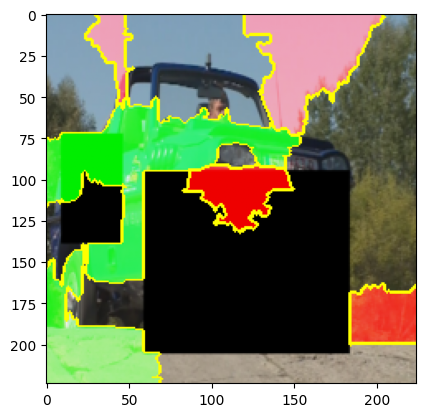

In [41]:
explanation_vision_transformer = explainer.explain_instance(
    image=lime_transformer(incorrect_amphibious_vehicle),
    classifier_fn=partial(predict_batch, vision_transformer),
    top_labels=5,
    num_samples=1000,
)

(
    image_vision_transformer,
    mask_vision_transformer,
) = explanation_vision_transformer.get_image_and_mask(
    label=explanation_vision_transformer.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
)

boundaries = mark_boundaries(image_vision_transformer, mask_vision_transformer)
plt.imshow(boundaries)

In [42]:
print("inception_v3")
get_prediction_probabilities(incorrect_amphibious_vehicle, inception_v3)
print()
print("vision_transformer")
get_prediction_probabilities(incorrect_amphibious_vehicle, vision_transformer)

inception_v3
Class: ashcan                         | Probability: 0.398806
Class: screen                         | Probability: 0.114961
Class: dishwasher                     | Probability: 0.099831
Class: television                     | Probability: 0.067440
Class: space_heater                   | Probability: 0.052805
Class: amphibian                      | Probability: 0.040459
Class: cassette_player                | Probability: 0.037843
Class: monitor                        | Probability: 0.033889
Class: convertible                    | Probability: 0.015277
Class: loudspeaker                    | Probability: 0.014471
Class: water_bottle                   | Probability: 0.013210
Class: desktop_computer               | Probability: 0.012381
Class: rain_barrel                    | Probability: 0.008487
Class: tape_player                    | Probability: 0.006913
Class: shopping_cart                  | Probability: 0.006649

vision_transformer
Class: forklift                      

O ile vision transformer od razu nie wykrywał odpowiedniego pojazdu, o tyle dwie pozostałe sieci dopiero po kilku próbach przestały go rozpoznawać. inception_v3 było w stanie poprawnie sklasyfikować pojazd nawet wtedy, gdy cały jego przód był zasłonięty

# Zadanie #3

Ponownie zmodyfikuj oryginalny obraz, ale tym razem zaszumiając go w losowy sposób (przykładowa implementacja: https://www.geeksforgeeks.org/add-a-salt-and-pepper-noise-to-an-image-with-python/). Czy najbardziej prawdopodobna klasa zmienia się wraz ze zmianą szumu? Przetestuj dla każdego z modeli.

In [43]:
import random
import cv2


def add_noise(img, q):
    row, col, _ = img.shape
    number_of_pixels = int(row * col * q)
    for i in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord][x_coord] = 255

    for i in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord][x_coord] = 0

    return img

In [44]:
vehicle_copy = np.copy(np.asarray(amphibious_vehicle))

salt_and_pepper_amphibias = [
    Image.fromarray(add_noise(vehicle_copy, i / 20)) for i in range(6)
]

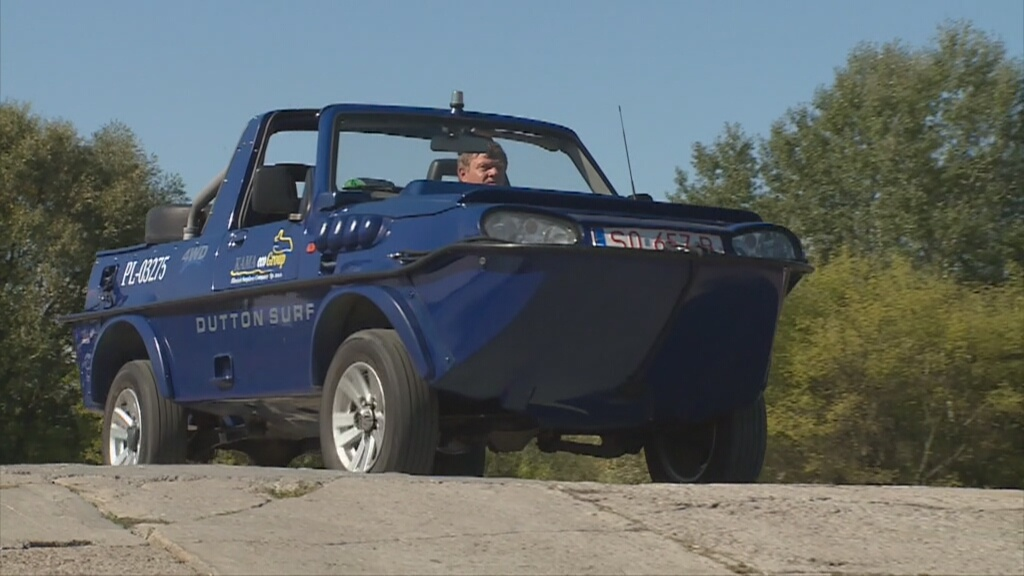

In [45]:
salt_and_pepper_amphibias[0]

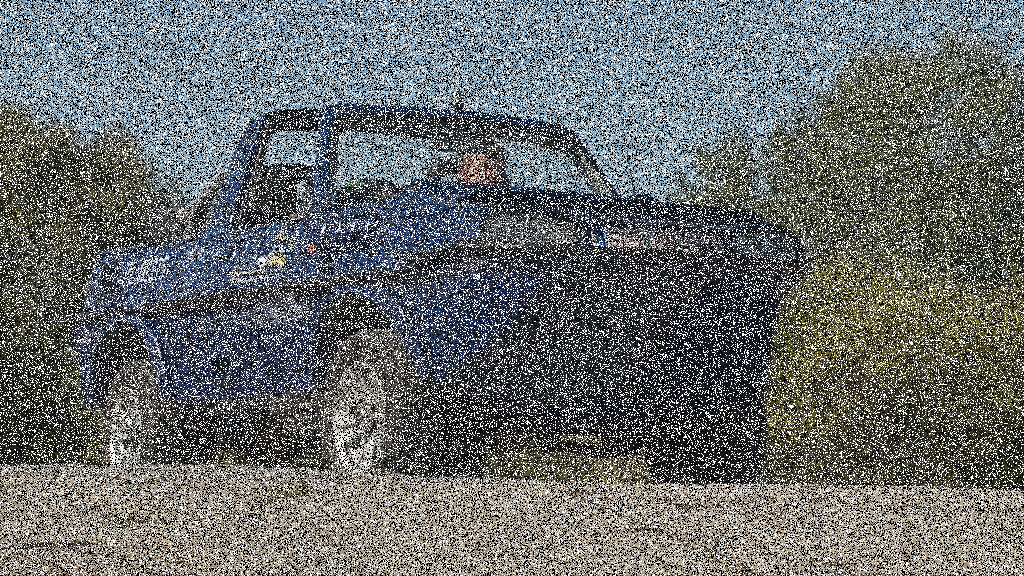

In [46]:
salt_and_pepper_amphibias[3]

In [47]:
TOP_N_LABELS = 3

In [48]:
models = [inception_v3, resnet, vision_transformer]
names = ["inception_v3", "resnet", "vision_transformer"]

for model, name in zip(models, names):
    print(name)
    for i, amp in enumerate(salt_and_pepper_amphibias):
        print((i) / 20)

        get_prediction_probabilities(amp, model)
    print()

inception_v3
0.0
Class: amphibian                      | Probability: 0.999999
Class: convertible                    | Probability: 0.000001
Class: racer                          | Probability: 0.000000
0.05
Class: amphibian                      | Probability: 0.999867
Class: jeep                           | Probability: 0.000059
Class: forklift                       | Probability: 0.000055
0.1
Class: tractor                        | Probability: 0.826292
Class: thresher                       | Probability: 0.095113
Class: snowplow                       | Probability: 0.048182
0.15
Class: tractor                        | Probability: 0.951766
Class: snowplow                       | Probability: 0.014947
Class: racer                          | Probability: 0.007327
0.2
Class: jigsaw_puzzle                  | Probability: 0.802692
Class: shower_curtain                 | Probability: 0.032959
Class: prayer_rug                     | Probability: 0.023552
0.25
Class: wool                   

Modele vision_transformer i resnet zaczęły dosyć szybko klasyfikować obraz jako zdjecie wycieraczki. Mimo, że inception_v3 również przestało wskazywać poprawną klasę, to jego błąd nie polegał na wykrywaniu wycieraczki.